#Computer Vision Final Project
##Image Generation with Conditional Generative Adversarial Network




## Imports

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (Dense, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose, Conv2D, Dropout, Flatten, Input, Embedding, Concatenate)
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import random
from keras.datasets.cifar10 import load_data


##Separate Test and Training Data
https://aicorespot.io/how-to-normalize-centre-and-standardize-image-pixels-in-keras/

We decided to use tensorflows built in slicing to shuffle and batch our data

set the base_image_shape to match the dimensions of the data set in order for the program to function.

In [ ]:
#TEST AND TRAINING SPLIT

''' we need the labels for training so that the images are converging within their label
 instead of across all the images. We don't use the test data '''


# (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
# base_image_shape = (28, 28, 1)

(train_images, train_labels), (test_images, test_labels) = load_data()
base_image_shape = (32, 32, 3)


'''make it a 4d numpy array, this is generalized that one the base_image_shape
is set for the data set,  the rest of the code should work off of that '''
train_images = train_images.reshape(train_images.shape[0], base_image_shape[0], base_image_shape[1], base_image_shape[2]).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

BUFFER_SIZE = 50000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices((train_labels, train_images)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

170498071/170498071 [==============================] - 6s 0us/step


##Generator Model Using CNN
The generator model takes in two inputs-- the noise seed (aka latent vector) and the label that should be generated. The foundational layers reshape both inputs to 2D vectors that can be combined and then the Concatenate layer combines them. Finally, the convolutional layers expand the combined inputs into the final 28x28 image.

How is the 28x28 calculated? If the input to a Conv2DTranspose layer is `(x, y, z)`, the output will be `(x * strides.x, y * strides.y, filters).`

In [ ]:
def create_generator_model(noise_shape, num_categories, output_shape):
    assert output_shape[0] % 4 == 0 and output_shape[1] % 4 == 0
    intermediate_shape = (output_shape[0] // 4, output_shape[1] // 4)

    label_input = Input((1,))
    embedded = Embedding(num_categories, 64)(label_input)
    label_foundation = Dense(intermediate_shape[0] * intermediate_shape[1], use_bias=False)(embedded)
    label_reshaped = Reshape((intermediate_shape[0], intermediate_shape[1], 1))(label_foundation)

    image_input = Input(noise_shape)
    image_foundation = Dense(intermediate_shape[0] * intermediate_shape[1] * 256, use_bias=False)(image_input)
    image_foundation_processed = LeakyReLU()(BatchNormalization()(image_foundation))
    image_reshaped = Reshape((intermediate_shape[0], intermediate_shape[1], 256))(image_foundation_processed)

    concatenated = Concatenate()([image_reshaped, label_reshaped])

    convolution_1 = Conv2DTranspose(filters=128, kernel_size=(4, 4), strides=(1, 1), padding='same', use_bias=False)(concatenated)
    convolution_1_processed = LeakyReLU()(BatchNormalization()(convolution_1))

    convolution_2 = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False)(convolution_1_processed)
    convolution_2_processed = LeakyReLU()(BatchNormalization()(convolution_2))

    convolution_final = Conv2DTranspose(output_shape[2], (4, 4), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(convolution_2_processed)

    return tf.keras.Model([image_input, label_input], convolution_final)


###Bad Generator Model
We made a bad generator model to test if loss is dependent on how good the model itself is

In [ ]:
def create_bad_generator_model(noise_shape, num_categories, output_shape=(28,28)):
    assert output_shape[0] % 4 == 0 and output_shape[1] % 4 == 0
    intermediate_shape = (output_shape[0] // 4, output_shape[1] // 4)

    label_input = Input((1,))
    embedded = Embedding(num_categories, 64)(label_input)
    label_foundation = Dense(intermediate_shape[0] * intermediate_shape[1], use_bias=False)(embedded)
    label_reshaped = Reshape((intermediate_shape[0], intermediate_shape[1], 1))(label_foundation)

    image_input = Input(noise_shape)
    image_foundation = Dense(intermediate_shape[0] * intermediate_shape[1] * 256, use_bias=False)(image_input)
    image_foundation_processed = LeakyReLU()(BatchNormalization()(image_foundation))
    image_reshaped = Reshape((intermediate_shape[0], intermediate_shape[1], 256))(image_foundation_processed)

    concatenated = Concatenate()([image_reshaped, label_reshaped])

    convolution_1 = Conv2DTranspose(filters=128, kernel_size=(1, 1), strides=(4, 4), padding='same', use_bias=False)(concatenated)
    # convolution_1_processed = LeakyReLU()(BatchNormalization()(convolution_1))

    return tf.keras.Model([image_input, label_input], convolution_1)

##Create Generator and Generate

Set the global `generator` to an untrained model that takes 100-length noise vectors and one of 10 labels.



In [ ]:
generator = create_generator_model(noise_shape=(100,), num_categories=10, output_shape=base_image_shape)

In [ ]:
print(generator.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 16384)        1638400     ['input_2[0][0]']                
                                                                                                  
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 16384)       65536       ['dense_1[0][0]']                
 alization)                                                                                   

Generates one or more images for a given label with a random noise seed for each and displays them. Uses `generator` at whatever state of training it's at.



In [ ]:
def generate_image(label, amount=1, show_image=True):
  noise = tf.random.normal([amount, 100])
  generated_label = tf.convert_to_tensor([label] * amount)
  generated_image = generator([noise, generated_label], training=False)

  if(show_image):
    is_color = generated_image[0, 0, 0, :].shape == (3,)
    if(is_color):
      plt.imshow(generated_image[0,:,:,:] / 2 + 0.5)
    else:
      plt.imshow(generated_image[0,:,:,0], cmap='gray')
  return (generated_image, generated_label)

## Demo `generate_image` function

(<tf.Tensor: shape=(3, 32, 32, 3), dtype=float32, numpy=
 array([[[[ 2.18458893e-03,  2.44476157e-03, -4.07883897e-04],
          [-1.17743353e-03, -3.71248368e-03,  2.98067625e-03],
          [ 1.62201468e-04,  6.51605707e-03, -5.04250231e-04],
          ...,
          [ 2.15401920e-03, -2.29328708e-03, -4.25571296e-03],
          [ 5.91658615e-03, -6.30305335e-03,  3.68460338e-03],
          [-2.65945587e-03,  3.07634939e-03,  4.56931826e-04]],
 
         [[-7.24751211e-04, -2.00721552e-03,  1.70535687e-03],
          [-2.32244772e-03,  5.72556513e-04,  1.14593189e-02],
          [ 2.92034564e-03, -1.95768140e-02,  1.97308511e-03],
          ...,
          [ 8.86987150e-03, -5.00787375e-03,  2.96667148e-03],
          [ 1.17704412e-02, -4.71175322e-03, -1.85572486e-02],
          [-8.73098383e-04,  2.64292606e-03, -2.17468594e-03]],
 
         [[-2.90649943e-03,  2.82403338e-03, -6.47895178e-03],
          [ 5.02941292e-03,  4.48772497e-03,  3.82310711e-03],
          [-2.15635076e-0

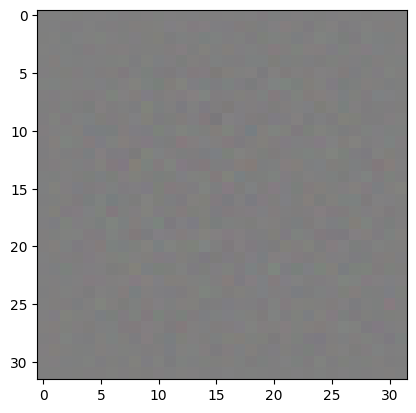

In [ ]:
generate_image(random.randint(0,9), amount=3)
# Random int determines which category it's generating for (not that it matters here)

##Descriminator Model
The discriminator model is similar to the generator model but reduces rather than expands the inputs. It takes two inputs-- the image it is trying to discriminate (real or fake) and the image's label.

The foundational layers reshape the label input to a 2D vector (not needed for the image input which is already 2D). The Concatenate layer combines the label and image, and then the convolutional layers reduce those values to a single output value representing the confidence that the input is a real image.

In [ ]:
def create_discriminator_model(image_shape, num_categories):
    label_input = Input((1,))
    embedded = Embedding(num_categories, 64)(label_input)
    label_foundation = Dense(image_shape[0] * image_shape[1], use_bias=False)(embedded)
    label_reshaped = Reshape((image_shape[0], image_shape[1], 1))(label_foundation)

    image_input = Input(image_shape)

    concatenated = Concatenate()([image_input, label_reshaped])

    convolution_1 = Conv2D(64, (4, 4), strides=(2, 2), padding='same')(concatenated)
    convolution_1_processed = Dropout(0.4)(LeakyReLU(.2)(convolution_1))

    convolution_2 = Conv2D(128, (4, 4), strides=(2, 2), padding='same')(convolution_1_processed)
    convolution_2_processed = Dropout(0.4)(LeakyReLU(.2)(convolution_2))

    convolution_3 = Conv2D(256, (4, 4), strides=(2, 2), padding='same')(convolution_2_processed)
    convolution_3_processed = Dropout(0.4)(LeakyReLU(.2)(convolution_3))

    flattened = Flatten()(convolution_3_processed)
    output = Dense(1)(flattened)

    return tf.keras.Model([image_input, label_input], output)

Set the global `discriminator` to an untrained model that takes 28x28 noise vectors and one of 10 labels.

In [ ]:
discriminator = create_discriminator_model(image_shape=base_image_shape, num_categories=10)
print(discriminator.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 64)        640         ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 1, 1024)      65536       ['embedding[0][0]']              
                                                                                                  
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                              

##Get Decision

Displays the output of `discriminator` on a given image and label (at its current level of training)

In [ ]:
def discriminate_image(image, label):
  decision = discriminator([image, label])
  print(decision)

Demo of `generate_image` and `discriminate_image` function together

It's still grey because they're still untrained at the start

tf.Tensor([[-0.0015922]], shape=(1, 1), dtype=float32)


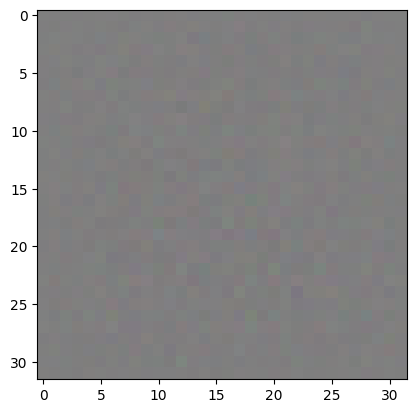

In [ ]:
(generated_image, generated_label) = generate_image(random.randint(0,9))
discriminate_image(generated_image, generated_label)

##Get Losses

In [ ]:
# This method returns a helper function to compute cross entropy loss
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#discriminator wants the real output to be ones and fake to be zeroes
def discriminator_loss(real_output, fake_output):
    # so the discriminator does cross entropy between ones and real output to find the difference
      # (because real output should be ones)
    real_loss = binary_cross_entropy(tf.ones_like(real_output), real_output)
    # and between the zeros and fake output
      # (because fake output should be zeros)
    fake_loss = binary_cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#wants the fake output to be ones (and thus appear real)
def generator_loss(fake_output):
    return binary_cross_entropy(tf.ones_like(fake_output), fake_output)

#set the learning rate here
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

##Save Checkpoints

In [ ]:
import os
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
#use the tensor flow train checkpoints
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

##Train Model

In [ ]:
EPOCHS = 100
num_examples_to_generate = 10
noise_dim = 100
# We reuse this seed across runs to show the gradual progress in the gif (think minecraft seed vibes)
image_seed = tf.random.normal([num_examples_to_generate, noise_dim])
# labels_seed = tf.experimental.numpy.random.randint(low=0, high=9, size=[num_examples_to_generate, 1])
labels_seed = tf.range(0, 10)

In [ ]:
# tf.function compiles function during training
  # https://www.tensorflow.org/api_docs/python/tf/function
@tf.function
def train_step(images, labels):
    # random noise generated to start off
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    generated_labels = tf.experimental.numpy.random.randint(low=0, high=9, size=[BATCH_SIZE, 1])

    # generate images and calculate loss values: data for generator and discriminator
    # GradientTape tracks differential operations
      # https://www.tensorflow.org/api_docs/python/tf/GradientTape
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator([noise, generated_labels], training=True)

      real_output = discriminator([images, labels], training=True)
      fake_output = discriminator([generated_images, generated_labels], training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    # Dynamic computation to get gradients (loss derivative stuff) for the generator and descriminator from their training data
      # record this in the gen tap and disc tape to keep track of it
    gradients_of_generator = gen_tape.gradient(gen_loss,
                                               generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss,
                                                discriminator.trainable_variables)

    # Apply gradients to optimizer
      # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Optimizer#apply_gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss


In [ ]:
import time
from IPython import display # A command shell for interactive computing in Python
  # (this documentation and display style is from the medium tutorial linked above)

def train(dataset, num_epochs):
  '''This is our training loop function that takes in the data set we're training the
  machine on and the number of epochs it will run for'''

  for epoch in range(num_epochs):
    start = time.time()
    # For each patch in epoch run the training step we created
    for batch in dataset:
      label_batch, image_batch = batch
      #take the losses to track progress throughout
      gen_loss, disc_loss = train_step(image_batch, label_batch)

    # create images for gif as it goes
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             image_seed,
                             labels_seed)

    # save a checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    # 4 - Print out the completed epoch no. and the time spent
    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    #discriminator wants to maximize loss and generator wants to minimize loss
    print(f"Epoch: {epoch} Loss D.: {disc_loss}")
    print(f"Epoch: {epoch} Loss G.: {gen_loss}")

  # final image after the training is completed
  display.clear_output(wait=True)
  generate_and_save_images(generator, num_epochs, image_seed, labels_seed)

##Image generation function

In [ ]:

def generate_and_save_images(model, epoch, test_input_noise, test_input_labels):
  '''Here we actually generate the images after our models have been trained,
  training param is set to false'''
  # generate images
  generated_imgs = model([test_input_noise, test_input_labels], training=False)
  # plot the generated images
  # this generation style is from the medium article to print a 3 by 3 section of our images
  fig = plt.figure(figsize=(4,4))
  for i in range(generated_imgs.shape[0]):
      plt.subplot(4, 4, i+1)
      is_color = generated_imgs[0, 0, 0, :].shape == (3,)
      if(is_color):
        plt.imshow(generated_imgs[i, :, :, :] / 2 + .5)
      else:
        plt.imshow(generated_imgs[i, :, :, 0])
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

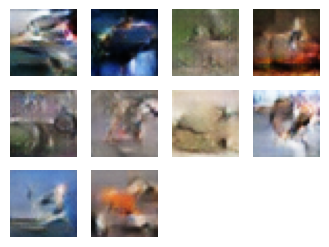

In [ ]:
train(train_dataset, EPOCHS)

# For CIFARS 10 the order is: plane, car, bird, cat, deer, dog, frog, horse, ship, truck

In [ ]:
#get checkpoints
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest_checkpoint)

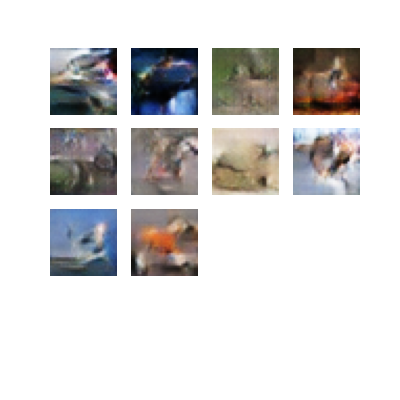

In [ ]:

#view evolution
# this code is from the medium article
# PIL is a library which may open different image file formats
import PIL
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)




In [ ]:
import glob # The glob module is used for Unix style pathname pattern expansion.
import imageio # The library that provides an easy interface to read and write a wide range of image data

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  # image = imageio.imread(filename)
  # writer.append_data(image)

display.Image(open('dcgan.gif','rb').read())